# Model Training

This notebook contains cleaning the text ingested in the `Data Ingestion` notebook and create supervised machine learning models to understand customer sentiment and evaluate them using a test set. 

### Contents:

1. [Data Exploration](#Data-Exploration)
2. [Text Cleaning](#Cleaning-Text)
3. [Logistic Regression]()
4. [Multinomial Naive Bayes]()


## Importing Libraries

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model  import LogisticRegression
from sklearn.naive_bayes import MultinomialNB

from sklearn.model_selection import GridSearchCV


from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler

from collections import Counter

import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from wordcloud import WordCloud

import warnings
warnings.filterwarnings("ignore")

## Importing Dataset

In [2]:
df = pd.read_csv('artifacts/data/Amazon_Reviews_Merged.csv')
df.head()

,overall,reviewText,category
0,4,Times have finally changed for Mac users when ...,Software
1,5,I am very surprised to really like this produc...,Luxury_Beauty
2,5,Very cute! And it's already wrapped! I just ad...,Gift_Cards
3,5,"I have been using ""Udderly Smooth"" (unscented)...",Luxury_Beauty
4,2,I found this shampoo difficult to lather. I re...,Luxury_Beauty


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63110 entries, 0 to 63109
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   overall     63110 non-null  int64 
 1   reviewText  63110 non-null  object
 2   category    63110 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.4+ MB


In [4]:
print(f'Shape of the dataset: {df.shape}')

Shape of the dataset: (63110, 3)


# Data Exploration

In [5]:
df.isna().sum()

overall       0
reviewText    0
category      0
dtype: int64

In [6]:
df.duplicated().sum()

22343

**Since, the data has a lot of duplicate values. We will drop them.**

In [7]:
df=df.drop_duplicates()
df.duplicated().sum()

0

### Plotting Value Counts of Sentiments

In [8]:
review_counts = df['overall'].value_counts()
review_counts

overall
5    21967
4     9840
3     4900
1     2126
2     1934
Name: count, dtype: int64

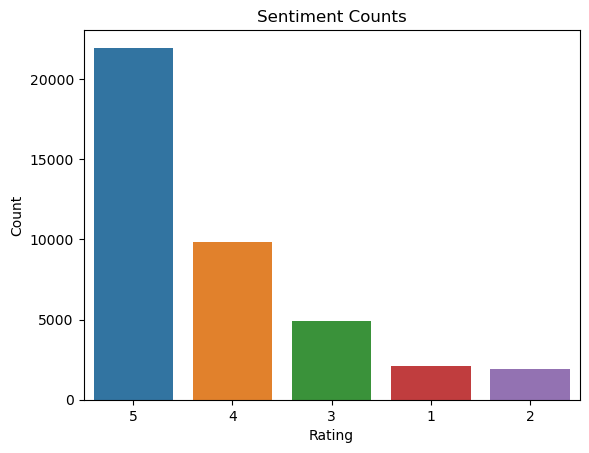

In [9]:
x_ = [str(i) for i in review_counts.index]
y_ = review_counts.values

sns.barplot(x=x_, y=y_)
plt.title('Sentiment Counts')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

# Cleaning Text

In [10]:
def clean_text(texts):
    cleaned_texts = []
    stopwords_eng = stopwords.words('english')
    count = 0
    for text in texts:
        #removing hyperlinks
        text_ = re.sub(r'https?://[^\s\n\r]+', ' ', text)
        #removing punctuations and digits, only taking words
        text_ = re.sub('[^a-zA-z]', ' ', text_)
        text_ = re.sub(r'[\W_]+', ' ', text_)
        text_ = text_.lower()
        words = nltk.word_tokenize(text_)
        words = [word for word in words if word not in stopwords_eng]
        cleaned_texts.append(' '.join(words))
        count += 1
        if count % 5000 == 0:
            print(f'Cleaned {count} text')
    print(f'Cleaned {count} text')
    print('Completed cleaning text')
    return np.array(cleaned_texts)

In [11]:
texts = df['reviewText'].copy()
texts.head()

0    Times have finally changed for Mac users when ...
1    I am very surprised to really like this produc...
2    Very cute! And it's already wrapped! I just ad...
3    I have been using "Udderly Smooth" (unscented)...
4    I found this shampoo difficult to lather. I re...
Name: reviewText, dtype: object

In [12]:
cleaned_texts = clean_text(texts)
cleaned_texts[:5]

Cleaned 5000 text
Cleaned 10000 text
Cleaned 15000 text
Cleaned 20000 text
Cleaned 25000 text
Cleaned 30000 text
Cleaned 35000 text
Cleaned 40000 text
Cleaned 40767 text
Completed cleaning text


array(['times finally changed mac users comes dictation mac seems mac always johnny come lately party far dictation involved first time mac users could finally say proper dictation arrived nuance offered dragon dictate mac since apple finally provided version dictation offered dictation mountain lion version os x nuance updated dragon dictate mac version taken years provide latest version mac users use dragon dictate mac intel based mac sorry power pc macs still using one running os minimum gb ram sit begin dictate without first teaching dragon dictate learn individual voice providing software sample speech learns voice sounds like way pronouncing different words input speech need utilize usb bluetooth microphone macs internal mike using ios android device using dragon remote microphone app tests utilized usb microphone voip headset mic hand setting dragon dictate hard long cumbersome immediately noticed lot faster previous version v used plugged usb microphone selected followed direct

In [13]:
lemmatizer = WordNetLemmatizer()
def lemmatize_text(texts):
    lem_texts = []
    count = 0
    for text in texts:
        lem_words = [lemmatizer.lemmatize(word) for word in nltk.word_tokenize(text)]
        lem_text = ' '.join(lem_words)
        lem_texts.append(lem_text)
        count += 1
        if count % 5000 == 0:
            print(f'Lemmatized {count} text')
    print(f'Lemmatized {count} text')
    return np.array(lem_texts)

In [14]:
lem_texts = lemmatize_text(cleaned_texts)
print(lem_texts[:5])

Lemmatized 5000 text
Lemmatized 10000 text
Lemmatized 15000 text
Lemmatized 20000 text
Lemmatized 25000 text
Lemmatized 30000 text
Lemmatized 35000 text
Lemmatized 40000 text
Lemmatized 40767 text
['time finally changed mac user come dictation mac seems mac always johnny come lately party far dictation involved first time mac user could finally say proper dictation arrived nuance offered dragon dictate mac since apple finally provided version dictation offered dictation mountain lion version o x nuance updated dragon dictate mac version taken year provide latest version mac user use dragon dictate mac intel based mac sorry power pc mac still using one running o minimum gb ram sit begin dictate without first teaching dragon dictate learn individual voice providing software sample speech learns voice sound like way pronouncing different word input speech need utilize usb bluetooth microphone mac internal mike using io android device using dragon remote microphone app test utilized usb mi

In [15]:
text = ' '.join(lem_texts)
chars = set(list(text))
print(chars)

{'d', 'g', 'x', 'j', 't', 'p', 'n', 'l', 'i', 'm', ' ', 'f', 'v', 'r', 'w', 'q', 'u', 'k', 'y', 'a', 'c', 'b', 's', 'z', 'h', 'o', 'e'}


In [25]:
print(f'Number of Words: {len(set(text.split()))}')

Number of Words: 36136


In [27]:
word_counts = Counter(text.split())
top_words = word_counts.most_common(1000)
for word, count in top_words:
    print(f' {word} : {count}')

 product : 29544
 like : 22707
 skin : 22606
 use : 21243
 one : 16121
 time : 12628
 work : 12386
 get : 12186
 good : 12158
 really : 11850
 would : 11793
 well : 11437
 using : 11328
 great : 11248
 used : 10945
 make : 10659
 software : 10544
 also : 9958
 program : 9717
 year : 9259
 much : 9242
 hair : 9097
 face : 8764
 feel : 8715
 love : 8591
 color : 8460
 look : 8424
 go : 8230
 day : 8071
 version : 8062
 window : 8022
 need : 7957
 even : 7930
 little : 7603
 nice : 7089
 scent : 6848
 cream : 6802
 bit : 6576
 way : 6571
 easy : 6435
 first : 6249
 better : 5989
 want : 5930
 computer : 5821
 still : 5765
 long : 5759
 smell : 5708
 lot : 5660
 new : 5630
 price : 5578
 thing : 5548
 dry : 5547
 eye : 5459
 think : 5433
 find : 5178
 see : 5129
 feature : 5093
 without : 5058
 many : 5056
 last : 5002
 file : 4972
 problem : 4957
 say : 4868
 user : 4808
 since : 4734
 light : 4715
 give : 4687
 come : 4518
 tried : 4467
 take : 4459
 video : 4318
 try : 4297
 could : 422

### Plotting a word cloud

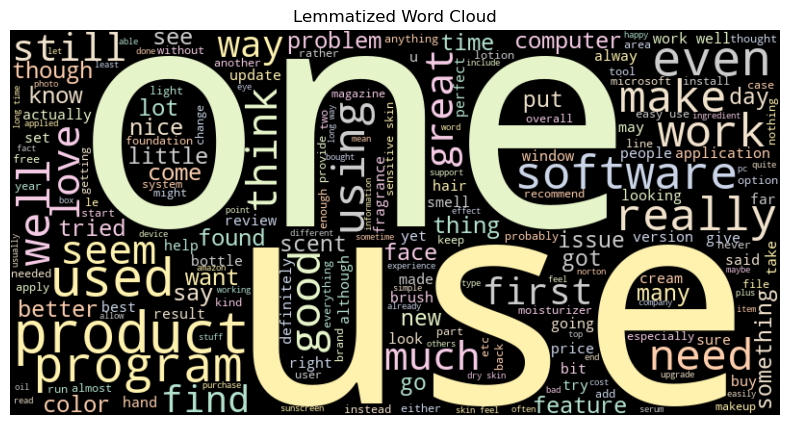

In [16]:
wordcloud = WordCloud(width=800, height=400, background_color="black", colormap='Pastel2').generate(text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Lemmatized Word Cloud")
plt.show()

## Spliting into train and test sets

In [17]:
print(f'Length of input: {len(lem_texts)}')
print(f'Length of output: {len(df["overall"])}')

Length of input: 40767
Length of output: 40767


**So we have 40767 samples. Splitting in test and train datasets** 

In [18]:
X = np.copy(lem_texts)
y = df['overall'].copy()
y = y - 1
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=2000)

In [19]:
print('Train Sample Size: ', X_train.shape, y_train.shape)
print('Test Sample Size: ', X_test.shape, y_test.shape)

Train Sample Size:  (38767,) (38767,)
Test Sample Size:  (2000,) (2000,)


## Vectorizing Text

In [36]:
tfidf_vec = TfidfVectorizer(max_features = 2000)
tfidf_vec.fit(X_train)

TfidfVectorizer(max_features=2000)

In [37]:
X_train_vec = tfidf_vec.transform(X_train).toarray()
print(f'Length of Vectorized Text Matrix : {X_train_vec.shape}')

Length of Vectorized Text Matrix : (38767, 2000)


### Scaling

In [38]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_vec)

# Logistic Regression 

In [39]:
logistic = LogisticRegression()

## Grid Searching Best Params

In [40]:
param_grid = {
    'max_iter': [100, 200],
    'multi_class': ['ovr', 'multinomial'],
    'C': [0.001, 0.01]  
}

grid_search = GridSearchCV(logistic, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_scaled, y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': [0.001, 0.01], 'max_iter': [100, 200],
                         'multi_class': ['ovr', 'multinomial']},
             scoring='accuracy')

In [41]:
print("Best Parameters: ", grid_search.best_params_)
print("Best Accuracy: ", grid_search.best_score_)

Best Parameters:  {'C': 0.001, 'max_iter': 100, 'multi_class': 'multinomial'}
Best Accuracy:  0.6117831728861245


In [42]:
best_logistic_model = grid_search.best_estimator_

### Evaluating

In [43]:
X_test_vec = tfidf_vec.transform(X_test).toarray()
X_test_scaled = scaler.transform(X_test_vec)

In [44]:
test_score = best_logistic_model.score(X_test_scaled, y_test)
print(f'Test Score: {test_score}')

Test Score: 0.6195
